# Import Libraries



In [ ]:
import torch
import torch.nn as nn
import torch.cuda as cuda
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

device  = 'cuda' if cuda.is_available() else 'cpu'

# Generate dataset with 15 independent variables and (256-15) dependent variables

In [ ]:
m = 500  # Number of rows
n_independent = 15  # Number of independent columns
n_total = 256  # Total number of columns
n_dependent = n_total - n_independent  # Number of dependent columns

independent_cols = torch.randn(m, n_independent)

W = torch.randn(n_independent, n_dependent)

dependent_cols = independent_cols @ W  # Shape: (m, n_dependent)
noise = torch.randn(m, n_dependent) * 10
dependent_cols = dependent_cols + noise

x_random = torch.cat([independent_cols, dependent_cols], dim=1)

# Normalize input data

In [ ]:
x_random_mean = torch.mean(x_random, dim=0) #(256)
x_random_std = torch.std(x_random, dim=0) #(256)
x_random_normalized = (x_random - x_random_mean)/x_random_std #(500, 256)
#x_random_normalized = x_random_normalized.unsqueeze(0)

# Dataloader

In [ ]:
def get_dataloader(x_random_normalized, batch_size):
  dataset = TensorDataset(x_random_normalized)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
  return dataloader

# Model

In [ ]:
class encoder(nn.Module):
  def __init__(self, xdim, latent_dim):
    super().__init__()
    self.latent_dim = latent_dim
    self.l1 = nn.Linear(xdim,128)
    self.l2 = nn.Linear(128,latent_dim)
    self.relu = nn.ReLU()

  def forward(self,x): #(1, batch_size, xdim)
    x = self.relu(self.l1(x)) #(1, batch_size, 128)
    x = self.relu(self.l2(x)) #(1, batch_size, 64)
    return x

In [ ]:
class decoder(nn.Module):
  def __init__(self, xdim, latent_dim):
    super().__init__()
    self.latent_dim = latent_dim
    self.l1 = nn.Linear(latent_dim,128)
    self.l2 = nn.Linear(128,xdim)
    self.relu = nn.ReLU()

  def forward(self,x): #(1, batch_size, 64)
    x = self.relu(self.l1(x)) #(1, batch_size, 128)
    x = self.l2(x) #(1, batch_size, xdim)
    return x

In [ ]:
class Model(nn.Module):
  def __init__(self, xdim, latent_dim):
    super().__init__()
    self.latent_dim = latent_dim
    self.encoder = encoder(xdim, latent_dim)
    self.decoder = decoder(xdim, latent_dim)

  def forward(self,x):
    y = self.encoder(x) #(1, batch_size, 64)
    x_hat = self.decoder(y) #(1, batch_size, xdim)
    return y, x_hat

# AE Custom Loss Function

In [ ]:
class Loss():
  def __init__(self, alpha = 0.00001):
    self.alpha = alpha

  def forward(self, x_batch, x_hat, y):
    diff = x_batch - x_hat #(1, batch_size, xdim)
    diff = diff.squeeze(0) #(batch_size, xdim)
    fro_norm = torch.norm(diff, p='fro') #scalar
    y = y.squeeze(0) #(batch_size, 64)
    yTransposeY = y.T @ y #(64, 64)
    identity = torch.eye(yTransposeY.shape[1])
    term2 = yTransposeY - identity #(64, 64)
    term2 = torch.norm(term2, p='fro') #scalar
    loss = (fro_norm**2 / diff.numel()) + self.alpha*(term2**2 / yTransposeY.numel()) #scalar
    return loss

# AEO Custom Loss Function

In [ ]:
class Loss():
  def __init__(self, alpha = 0.01, beta=0.01, gamma=0.01):
    self.alpha = alpha
    self.beta = beta
    self.gamma = gamma
    self.A = self.extract_parameters(model)

  def extract_parameters(self, model):
    params = []
    for name, param in model.named_parameters():
      if "encoder" in name or "decoder" in name:
        params.append(param.view(-1))

    A = torch.cat(params)
    return A

  def forward(self, x_batch, x_hat, y):
    diff = x_batch - x_hat #(1, batch_size, xdim)
    fro_norm = torch.norm(diff, p='fro') #scalar
    y = y.squeeze(0) #(batch_size, 64)
    y_mean = torch.mean(y, dim=0) #(64)
    y = y - y_mean #(batch_size, 64)
    q = torch.arange(1, y.shape[0] + 1, dtype=torch.float32)
    Q = torch.diag(q) #(batch_size, batch_size)
    term2 = y.T @ Q @ y #(64, 64)
    term3 = torch.norm(self.A, p='fro') #scalar
    loss = self.alpha*(fro_norm**2 / diff.numel()) + self.beta*torch.trace(term2)/y.shape[0] + self.gamma*(term3**2 / self.A.numel())
    #loss = self.alpha*(fro_norm**2 / diff.numel()) + self.gamma*(term3**2 / self.A.numel())
    return loss

# T square metric

In [ ]:
def calculate_T_squared(y, epsilon):
    # Compute covariance matrix of the latent space
    y = y.squeeze(0)
    covariance_matrix = torch.cov(y.T)  # Covariance matrix of y
    covariance_matrix += torch.eye(covariance_matrix.size(0)) * epsilon
    covariance_inv = torch.inverse(covariance_matrix)  # Inverse of covariance matrix

    # Compute T^2 for each sample
    T_squared = torch.matmul(y, covariance_inv) * y  # T^2 = y^T C_inv y

    return T_squared

# Hyperparameters

In [ ]:
num_epochs = 100
learning_rate = 1e-9
batch_size = 30
latent_dim = 64
alpha = 0.01
beta = 0.01
gamma = 0.01
epsilon = 1e-6

model = Model(n_total, latent_dim)

#AE loss function
#loss_fn = Loss(alpha)

#AEO loss function
loss_fn = Loss(alpha, beta, gamma)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
dataloader = get_dataloader(x_random_normalized, batch_size)

# Initial Variance of Latent Variable

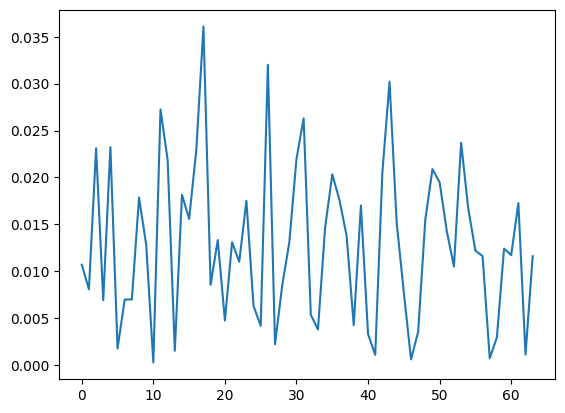

In [ ]:
y1, _ = model(x_random_normalized.unsqueeze(0))
y1_var = torch.var(y1.squeeze(), axis=0)
plt.plot(y1_var.detach().numpy())
plt.show()

# Train

In [ ]:
def train_model(model, dataloader, loss_fn, optimizer, num_epochs, device):
    model.train()
    model.to(device)
    losses = []
    T_squared_values = []

    for epoch in range(num_epochs):
      epoch_loss = 0
      epoch_T_squared = torch.zeros(model.latent_dim, device=device)
      for i, x_batch in enumerate(dataloader):
        optimizer.zero_grad()
        x_batch_tensor  = x_batch[0].unsqueeze(0).to(device) #(1, batch_size, xdim)
        y, x_hat = model(x_batch_tensor)
        loss = loss_fn.forward(x_batch_tensor, x_hat, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        T_squared_contributions = calculate_T_squared(y, epsilon)
        epoch_T_squared += T_squared_contributions.sum(dim=0)  # Sum over samples for each dimension
      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader)}')
      losses.append(epoch_loss/len(dataloader))
      T_squared_values.append(epoch_T_squared.cpu().detach().numpy())

    return model, y, losses, T_squared_values

model, y, losses, T_squared_values = train_model(model, dataloader, loss_fn, optimizer, num_epochs, device)
# Average T^2 contributions across epochs
average_T_squared_contributions = (sum(T_squared_values) / len(T_squared_values))

Epoch [1/100], Loss: 0.15966776714605443
Epoch [2/100], Loss: 0.15885080484782949
Epoch [3/100], Loss: 0.1596194089335554
Epoch [4/100], Loss: 0.1584871016881045
Epoch [5/100], Loss: 0.15932698766974843
Epoch [6/100], Loss: 0.15820196095634909
Epoch [7/100], Loss: 0.15912045801387115
Epoch [8/100], Loss: 0.15854572504758835
Epoch [9/100], Loss: 0.15927467013106628
Epoch [10/100], Loss: 0.1567530351526597
Epoch [11/100], Loss: 0.15744202014277964
Epoch [12/100], Loss: 0.15948575296822717
Epoch [13/100], Loss: 0.15847875616129706
Epoch [14/100], Loss: 0.1598895770661971
Epoch [15/100], Loss: 0.15838376388830297
Epoch [16/100], Loss: 0.16042788414394155
Epoch [17/100], Loss: 0.1590136609533254
Epoch [18/100], Loss: 0.1583282544332392
Epoch [19/100], Loss: 0.1583385300986907
Epoch [20/100], Loss: 0.15938056786270702
Epoch [21/100], Loss: 0.1598349366994465
Epoch [22/100], Loss: 0.15990716481910033
Epoch [23/100], Loss: 0.1570327970034936
Epoch [24/100], Loss: 0.1573142830063315
Epoch [25/1

# Plots

Text(0.5, 1.0, 'Training Loss')

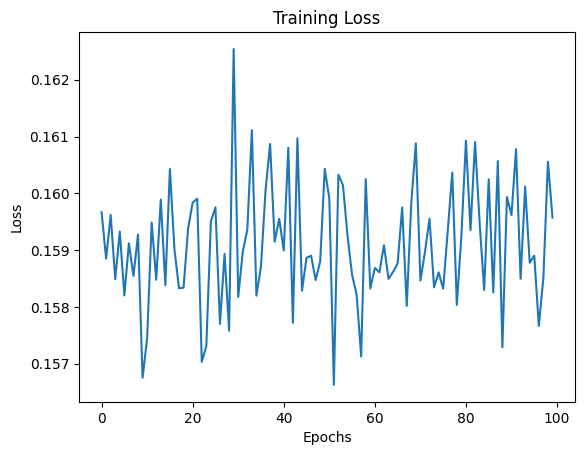

In [ ]:
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")

Text(0.5, 1.0, 'T^2 Metric')

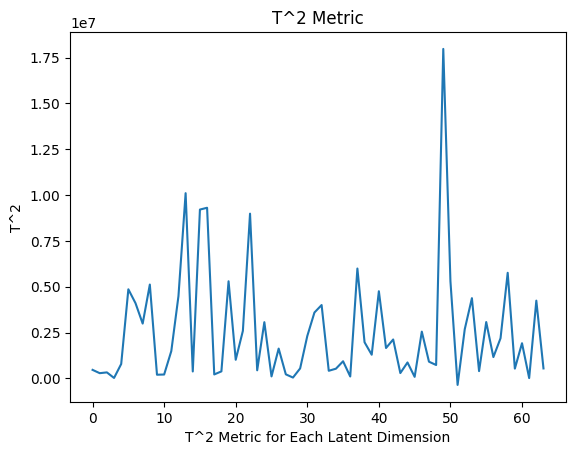

In [ ]:
plt.plot(average_T_squared_contributions)
plt.xlabel("T^2 Metric for Each Latent Dimension")
plt.ylabel("T^2")
plt.title("T^2 Metric")

# Variance of Latent Variable after training

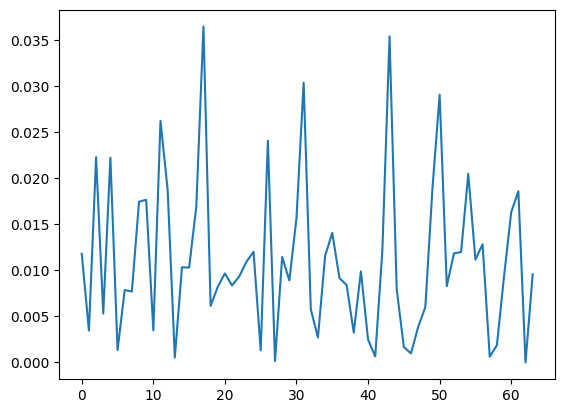

In [ ]:
y_var = torch.var(y.squeeze(0), axis=0)
plt.plot(y_var.detach().numpy())
plt.show()

# PCA

In [ ]:
def calculate_T_squared_PCA_per_dimension(x_random_normalized):
    data = x_random_normalized.cpu().numpy()

    # Apply PCA
    pca = PCA(n_components=min(data.shape))
    pca.fit(data)
    principal_components = pca.components_
    projected_data = np.dot(data, principal_components.T)

    covariance_matrix = np.cov(projected_data.T)
    covariance_inv = np.linalg.inv(covariance_matrix)

    # Calculate T^2 contributions per dimension
    T_squared_contributions = np.dot(projected_data, covariance_inv) * projected_data

    # Calculate total T^2 and average T^2
    T_squared = np.sum(T_squared_contributions, axis=1)  # Total T^2 per sample
    avg_T_squared_per_dimension = np.mean(T_squared_contributions, axis=0)  # Average T^2 per dimension

    return avg_T_squared_per_dimension, T_squared

# Plots

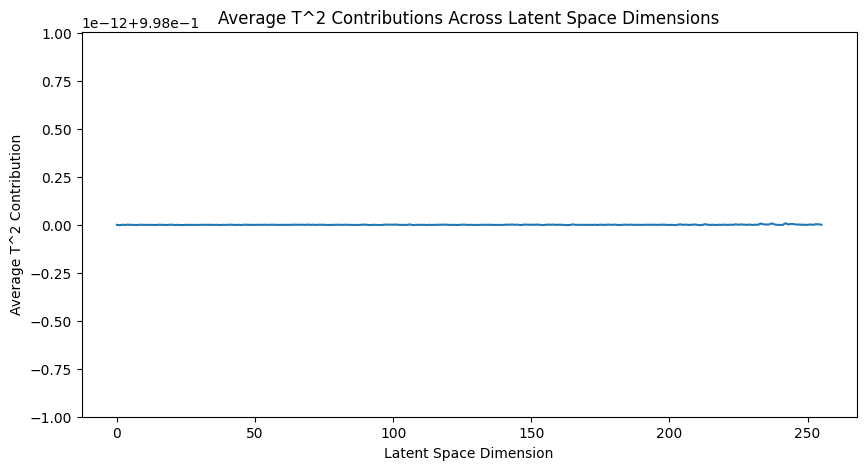

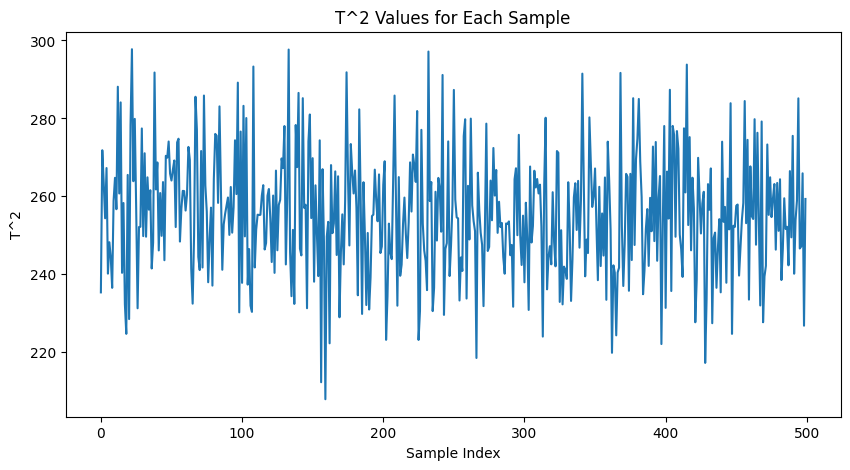

In [ ]:
avg_T_squared_per_dimension, T_squared_values = calculate_T_squared_PCA_per_dimension(x_random_normalized)

plt.figure(figsize=(10, 5))
plt.plot(range(len(avg_T_squared_per_dimension)), avg_T_squared_per_dimension)
plt.title("Average T^2 Contributions Across Latent Space Dimensions")
plt.xlabel("Latent Space Dimension")
plt.ylabel("Average T^2 Contribution")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(T_squared_values)
plt.title("T^2 Values for Each Sample")
plt.xlabel("Sample Index")
plt.ylabel("T^2")
plt.show()